In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch 
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn import preprocessing 
import torch.nn as nn
import torch.utils.data
label_encoder = preprocessing.LabelEncoder()

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print("Table names: ", filename)
        fullPath = os.path.join(dirname, filename)
        
        
        if filename == "train.csv":
            trainDS = pd.read_csv(fullPath)
            trainDS = trainDS[1:1000]
        if filename == "test.csv":
            testDS = pd.read_csv(fullPath)
        
        
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Table names:  sample_submission.csv
Table names:  train.csv
Table names:  test.csv


In [2]:
## using hardware accelerators
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("Using GPU: ", torch.cuda.get_device_name(0))
elif 'XLA_USE_BF16' in os.environ:  # This is how TPUs are usually detected in Kaggle
    import torch_xla.core.xla_model as xm
    device = xm.xla_device()
    print("Using TPU")
else:
    device = torch.device('cpu')
    print("Using CPU")

Using CPU


In [3]:
## The plan
#Split up engine type into the following columns
#HP, engine size (without the Liter), cylinder number (sometimes says X cylinder, sometimes VX or IX),fuel type

#encode brand, model, fuel_type, ext_col, int_col, accident, clean_title

#label is obviously price
print(trainDS.head(1))

   id    brand  model  model_year  milage fuel_type  \
1   1  Lincoln  LS V8        2002  143250  Gasoline   

                                         engine transmission ext_col int_col  \
1  252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel          A/T  Silver   Beige   

                                 accident clean_title  price  
1  At least 1 accident or damage reported         Yes   4999  


In [4]:
#Taking a look at what engines have HP in them or not
'''## Data preprocessing block (from above plan)
#print(trainDS.head(20))
print(trainDS["engine"].value_counts())
print(len(trainDS) - trainDS['engine'].str.contains("HP").sum())
print(trainDS['engine'].str.contains("HP").sum())

unique_non_occurrences = trainDS[~trainDS['engine'].str.contains('HP')]['engine'].unique()
print(unique_non_occurrences)'''

'## Data preprocessing block (from above plan)\n#print(trainDS.head(20))\nprint(trainDS["engine"].value_counts())\nprint(len(trainDS) - trainDS[\'engine\'].str.contains("HP").sum())\nprint(trainDS[\'engine\'].str.contains("HP").sum())\n\nunique_non_occurrences = trainDS[~trainDS[\'engine\'].str.contains(\'HP\')][\'engine\'].unique()\nprint(unique_non_occurrences)'

In [5]:
def preprocess(df):
    # Ensure the input is a DataFrame
    if not isinstance(df, pd.DataFrame):
        print("Variable is not a dataframe.")
        raise SystemExit("Stopping execution due to incorrect input.")

    # Check if 'engine' column exists
    columnSet = ["engine"]
    if set(columnSet).issubset(df.columns):
        print("'engine' column found, processing...")
        
        # Split the 'engine' column
        try:
            columnAdditions = df["engine"].str.split('HP', expand=True)
            intermVar = columnAdditions[1].str.split("L", expand=True)
            columnAdditions = pd.concat([columnAdditions, intermVar], axis=1)

            # Cleanup column names
            columnAdditions.columns = [0, 1, 2, 3]  # Give temporary names
            columnAdditions = columnAdditions.rename(columns={0: "HP", 2: "engine_size"})
            columnAdditions = columnAdditions.drop([1, 3], axis=1)  # Drop unnecessary columns

            # Convert to numeric values
            columnAdditions["HP"] = pd.to_numeric(columnAdditions["HP"], errors='coerce')
            columnAdditions["engine_size"] = pd.to_numeric(columnAdditions["engine_size"], errors='coerce')

            # Merge back with the original DataFrame
            newdf = pd.concat([df, columnAdditions], axis=1)
            newdf = newdf.drop("engine", axis=1)  # Drop the original 'engine' column

            print("Processing complete. Returning new DataFrame.")
            return newdf

        except KeyError as e:
            print(f"KeyError: {e} - One of the expected columns is missing.")
        except Exception as e:
            print(f"An error occurred: {e}")

    else:
        print("'engine' column is not in the DataFrame (it might have already been processed).")
        return df  # Return the original DataFrame if no processing was done


In [6]:
def encodeData(df, columnSet):
    #make sure ds is dataframe
    if isinstance(df, pd.DataFrame):
        pass
    else:
        print("Variable is not dataframe")
        #raise SystemExit("Stop right there!")
       
    #make sure column names are all valid 
    if set(columnSet).issubset(df.columns):
        pass
    else:
        print("Col list invalid")
        #raise SystemExit("Stop right there!")
    
    #encode all specified columns
    for column in columnSet:
        df[column] = label_encoder.fit_transform(df[column])
    
    return df

In [7]:
#load and process data
batch_size = 32

class carDataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.df = df
        
        #call engine preprocess method to preprocess the engines (split into HP and engine size)
        self.df = preprocess(self.df)
        self.df = encodeData(self.df, ["model", "brand", "fuel_type", "transmission", "ext_col", "int_col", "accident", "clean_title"])
        
        self.df = self.df.replace(np.nan,0)
        
        self.labels = self.df[["price"]]   #y is just the price (this for )
        self.labels=( self.labels- self.labels.min())/( self.labels.max()- self.labels.min())
        
        self.features = self.df.drop(["price"], axis = 1)  #x is dataframe with price column dropped 
        self.features = (self.features - self.features.mean())/self.features.std() 
            
    def __getitem__(self, idx):
        # Convert the features and labels to PyTorch tensors
        features_tensor = torch.tensor(self.features.iloc[idx], dtype=torch.float32).to(device)
        labels_tensor = torch.tensor(self.labels.iloc[idx], dtype=torch.float32).to(device)
        
        return features_tensor, labels_tensor
 
    
    def __len__(self):
        return len(self.features)
    
carDataset = carDataset(trainDS)
trainer = DataLoader(carDataset, batch_size = batch_size, shuffle = True)

'engine' column found, processing...
Processing complete. Returning new DataFrame.


In [8]:
#load and process data
batch_size = 32

class carDataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.df = df
        
        #call engine preprocess method to preprocess the engines (split into HP and engine size)
        self.df = preprocess(self.df)
        self.df = encodeData(self.df, ["model", "brand", "fuel_type", "transmission", "ext_col", "int_col", "accident", "clean_title"])
        
        self.df = self.df.replace(np.nan,0)
        
        self.labels = self.df[["price"]]   #y is just the price (this for )
        self.features = self.df.drop(["price"], axis = 1)  #x is dataframe with price column dropped
        print(self.features)
        
        self.features = (self.features - self.features.mean())/self.features.std() 
            
    def __getitem__(self, idx):
        # Convert the features and labels to PyTorch tensors
        features_tensor = torch.tensor(self.features.iloc[idx], dtype=torch.float32).to(device)
        labels_tensor = torch.tensor(self.labels.iloc[idx], dtype=torch.float32).to(device)
        
        return features_tensor, labels_tensor
 
    
    def __len__(self):
        return len(self.features)

In [9]:
'''#initial random trees 

import ydf
learner = ydf.GradientBoostedTreesLearner(
    num_trees=15,
    label="price",
    min_examples = 3,
    random_seed = 1,
)

trainDS = encodeData(preprocess(trainDS), ["model", "brand", "fuel_type", "transmission", "ext_col", "int_col", "accident", "clean_title"])
#print(trainDS.head)
model = learner.train(trainDS)
testDS = encodeData(preprocess(testDS), ["model", "brand", "fuel_type", "transmission", "ext_col", "int_col", "accident", "clean_title"])
predict = model.predict(testDS)
model.describe()'''

'#initial random trees \n\nimport ydf\nlearner = ydf.GradientBoostedTreesLearner(\n    num_trees=15,\n    label="price",\n    min_examples = 3,\n    random_seed = 1,\n)\n\ntrainDS = encodeData(preprocess(trainDS), ["model", "brand", "fuel_type", "transmission", "ext_col", "int_col", "accident", "clean_title"])\n#print(trainDS.head)\nmodel = learner.train(trainDS)\ntestDS = encodeData(preprocess(testDS), ["model", "brand", "fuel_type", "transmission", "ext_col", "int_col", "accident", "clean_title"])\npredict = model.predict(testDS)\nmodel.describe()'

In [10]:
seed = 0
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

In [11]:
n = 60

class usedCarModel(nn.Module):
    def __init__(self, input_size, batch_size):
        super(usedCarModel, self).__init__()
        self.input_size = input_size
        self.batch_size = batch_size
        
        # Define the layers
        self.fc1 = nn.Linear(input_size, n*512)  # First hidden layer
        self.bn1 = nn.BatchNorm1d(n*512)         # Batch Normalization for first hidden layer
        self.fc2 = nn.Linear(n*512,n*256)        # Second hidden layer
        self.bn2 = nn.BatchNorm1d(256*n)         # Batch Normalization for second hidden layer
        self.fc3 = nn.Linear(256*n, 128*n)       # Third hidden layer
        self.bn3 = nn.BatchNorm1d(128*n)         # Batch Normalization for third hidden layer
        self.fc4 = nn.Linear(128*n, 64*n)        # Fourth hidden layer
        self.fc5 = nn.Linear(64*n, 1)            # Output layer
        
        # Activation function
        self.relu = nn.ReLU()
        # Dropout for regularization
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, x):
        # Forward pass
        x = x.to(device)
        x = self.relu(self.bn1(self.fc1(x)))  # First layer + BatchNorm + activation
        x = self.dropout(x)                   # Dropout layer
        x = self.relu(self.bn2(self.fc2(x)))  # Second layer + BatchNorm + activation
        x = self.dropout(x)                   # Dropout layer
        x = self.relu(self.bn3(self.fc3(x)))  # Third layer + BatchNorm + activation
        x = self.relu(self.fc4(x))            # Fourth layer + activation
        x = self.fc5(x)                       # Output layer
        return x


#model / hyperparameter definitions
num_epochs = 100
learning_rate = 0.0001
input_size = trainDS.shape[1]
model = usedCarModel(input_size, batch_size)
model = model.to(device)
criterion = nn.MSELoss()
opt = optim.Adam(model.parameters(), lr = learning_rate)

lossVec = np.zeros(num_epochs)

accuracyVec = np.zeros(num_epochs)

In [12]:
#Reduce LR Scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, 'min', factor = 0.7, patience = 2)

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    total_output = []
    total_mae = 0.0
    
    for batch_idx, (inputs, labels) in enumerate(trainer):
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = model(inputs).to(device)
        
        #print("Average label: ", sum(labels)/len(labels), "average output: ",sum(outputs)/len(outputs))
       
        total_output.append(outputs.cpu().detach().numpy())
        
        loss = criterion(outputs, labels.float())
                         
        # Backward pass and optimization
        opt.zero_grad()
        loss.backward()
        opt.step()
        scheduler.step(running_loss)

        # Accumulate loss
        running_loss += loss.item()

        # Calculate precision and accuracy
        # Calculate MAE for this batch
        batch_mae = torch.mean(torch.abs(outputs - labels)).item()
        total_mae += batch_mae
        
    # Calculate average loss and accuracy for the epoch
    epoch_loss = running_loss / len(trainer)
    lossVec[epoch] = epoch_loss
    accuracyVec[epoch] = total_mae
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, MAE: {total_mae:.4f}, Learning Rate: {learning_rate}')
    
    mean_epoch_output = sum(outputs.cpu().detach().numpy()) / len(outputs.cpu().detach().numpy())
    print("Mean epoch output: ",mean_epoch_output)
    
total_output = np.concatenate(total_output)

/tmp/ipykernel_16/4091963302.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  features_tensor = torch.tensor(self.features.iloc[idx], dtype=torch.float32).to(device)
/tmp/ipykernel_16/4091963302.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels_tensor = torch.tensor(self.labels.iloc[idx], dtype=torch.float32).to(device)


Epoch [1/100], Loss: 1.1795, MAE: 19.2530, Learning Rate: 0.0001
Mean epoch output:  [-0.04859146]
Epoch [2/100], Loss: 0.0303, MAE: 4.3515, Learning Rate: 0.0001
Mean epoch output:  [-0.0050769]
Epoch [3/100], Loss: 0.0264, MAE: 4.0608, Learning Rate: 0.0001
Mean epoch output:  [0.01433583]
Epoch [4/100], Loss: 0.0273, MAE: 4.1121, Learning Rate: 0.0001
Mean epoch output:  [0.01292081]
Epoch [5/100], Loss: 0.0255, MAE: 3.9611, Learning Rate: 0.0001
Mean epoch output:  [-0.01407153]
Epoch [6/100], Loss: 0.0256, MAE: 4.0031, Learning Rate: 0.0001
Mean epoch output:  [-0.04590573]
Epoch [7/100], Loss: 0.0248, MAE: 3.9194, Learning Rate: 0.0001
Mean epoch output:  [-0.01116]
Epoch [8/100], Loss: 0.0237, MAE: 3.8732, Learning Rate: 0.0001
Mean epoch output:  [0.019596]
Epoch [9/100], Loss: 0.0240, MAE: 3.9431, Learning Rate: 0.0001
Mean epoch output:  [-0.0177736]
Epoch [10/100], Loss: 0.0238, MAE: 3.8636, Learning Rate: 0.0001
Mean epoch output:  [-0.02574269]
Epoch [11/100], Loss: 0.0212

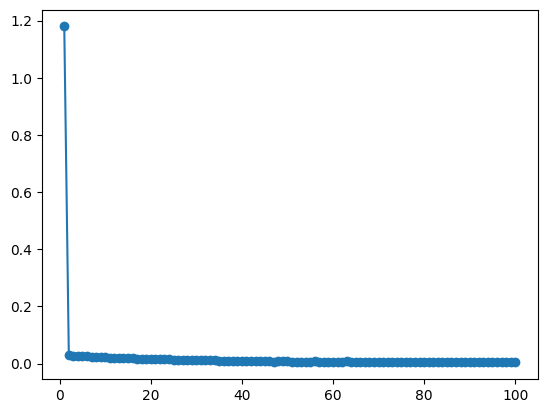

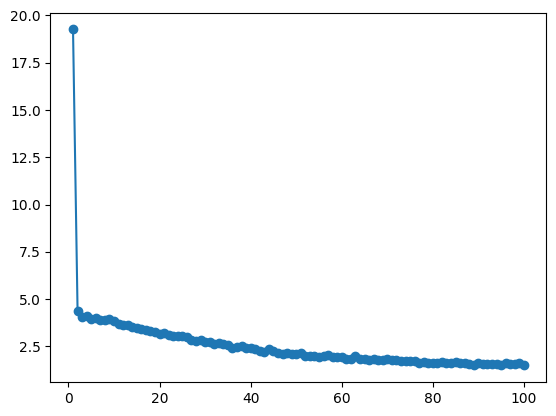

In [13]:
# plot loss
import matplotlib.pyplot as plt
epochVec = np.arange(1,num_epochs+1)

plt.figure(1)
plt.plot(epochVec, lossVec,'o-')
plt.figure(2)
plt.plot(epochVec, accuracyVec,'o-')
